In [92]:
import pandas as pd
import numpy as np
import os
from statistics import mean
# Machine Learning Libraries
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
# Randomized Search of Hyperparameters
from scipy.stats import randint
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import GridSearchCV

# Analysis of accuracy
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
# Export the tree
from sklearn.tree import export_graphviz
# Convert to png using system command
from subprocess import call

# Feature Importance
from sklearn.inspection import permutation_importance

#Work with plots
import matplotlib.pyplot as plt

# Training and testing sampling
# to ensure sam proportion of samples
# in training and testing compared
# with the whole dataset proportion
from sklearn.model_selection import train_test_split
from collections import Counter

# Cross validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

# Scale Data
from sklearn.preprocessing import StandardScaler,MinMaxScaler

In [93]:
# load in training and test data
train = pd.read_csv('training.csv')
test = pd.read_csv('testing.csv')
print("Rows and Columns(Train): ",train.shape)
print("Rows and Columns(Test) : ",test.shape)

Rows and Columns(Train):  (168, 148)
Rows and Columns(Test) :  (507, 148)


In [94]:
# check for missing values although it is clear there are none
train.isnull().any().any()

False

In [95]:
# duplicate function of pandas returns a duplicate row as true and others as false
sum(train.duplicated())

0

In [96]:
# target variable defined
Y_train = train["class"].copy()
Y_test  = test["class"].copy()
Y_train.value_counts()

grass        29
building     25
concrete     23
tree         17
shadow       16
car          15
pool         15
asphalt      14
soil         14
Name: class, dtype: int64

In [97]:
#Define the model and datasets for training and testing (all features)
X_train = train.iloc[:,1:148]
X_test  = test.iloc[:,1:148]
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((168, 147), (168,), (507, 147), (507,))

In [98]:
#Run KNN grid search with all features
#No scaling
params = {
    'n_neighbors':  list(range(1, 1000, 1)),
    'p': [1,2],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

#Random Search of Best Parameters
gs = GridSearchCV(
    KNeighborsClassifier(), 
    params, 
    verbose=1, 
    cv=5,
    n_jobs=-1
)

# Fit the model
gs_results = gs.fit(X_train, Y_train)

#Display the best parameters
pars = str(gs_results.best_params_)
pars = pars.replace(",", ",\n")

#Get the classifier with the best parameters
clf_best = gs_results.best_estimator_
Y_hat = clf_best.predict(X_test)

# mean accuracy test dataset
the_score = gs_results.best_score_
the_accuracy = clf_best.score(X_test, Y_test)
#Classification Error (Testing Error Rate)
the_error = np.mean(Y_hat != Y_test)


Fitting 5 folds for each of 7992 candidates, totalling 39960 fits


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [0.48680927 0.48680927 0.48680927 ...        nan        nan        nan]
  warnings.warn(


In [99]:
#Best Parameters
#All features (No Scaled)
pars

"{'metric': 'manhattan',\n 'n_neighbors': 4,\n 'p': 1,\n 'weights': 'distance'}"

In [100]:
#All features (No Scaled)
# Accuracy and error
print("Accuracy: %s. Score: %s. Error: %s" % (the_accuracy, the_score, the_error))

Accuracy: 0.5424063116370809. Score: 0.6242424242424243. Error: 0.45759368836291914


In [101]:
# Accuracy
# Not Scaled (All Features)
the_accuracy_ns = the_accuracy

In [102]:
#Scale the data
#All features
scaler = StandardScaler() #standardize data values into standard format
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

In [103]:
#Run KNN grid search with all features
#Scaling
params = {
    'n_neighbors':  list(range(1, 1000, 1)),
    'p': [1,2],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

#Random Search of Best Parameters
gs = GridSearchCV(
    KNeighborsClassifier(), 
    params, 
    verbose=1, 
    cv=5,
    n_jobs=-1
)

# Fit the model
gs_results = gs.fit(X_train_std, Y_train)

#Display the best parameters
pars = str(gs_results.best_params_)
pars = pars.replace(",", ",\n")

#Get the classifier with the best parameters
clf_best = gs_results.best_estimator_
Y_hat = clf_best.predict(X_test_std)

# mean accuracy test dataset
the_score = gs_results.best_score_
the_accuracy = clf_best.score(X_test_std, Y_test)
#Classification Error (Testing Error Rate)
the_error = np.mean(Y_hat != Y_test)

Fitting 5 folds for each of 7992 candidates, totalling 39960 fits


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [0.74313725 0.74313725 0.74313725 ...        nan        nan        nan]
  warnings.warn(


In [104]:
#Best Parameters
#All features (Scaled)
pars

"{'metric': 'manhattan',\n 'n_neighbors': 8,\n 'p': 1,\n 'weights': 'distance'}"

In [105]:
#All features (Scaled)
# Accuracy and error
print("Accuracy: %s. Score: %s. Error: %s" % (the_accuracy, the_score, the_error))

Accuracy: 0.777120315581854. Score: 0.8274509803921569. Error: 0.22287968441814596


In [106]:
# Accuracy
# Scaled (All Features)
the_accuracy_s = the_accuracy

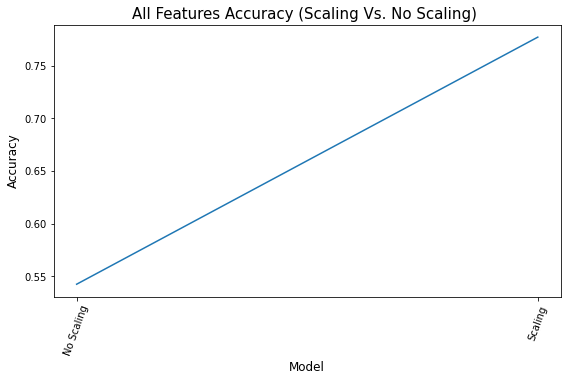

In [107]:
#Plot results All Features (Scaled vs Not Scaled Accuracy)
fig = plt.figure(figsize=(20,5))
plt.subplot(121)
plt.plot([0, 1], [the_accuracy_ns, the_accuracy_s]); plt.xticks([0, 1], ["No Scaling", "Scaling"])
plt.title("All Features Accuracy (Scaling Vs. No Scaling) ",fontsize = 15)
plt.xlabel('Model',fontsize = 12)
plt.xticks(rotation = 70)
plt.ylabel('Accuracy',fontsize = 12)
plt.show()

In [108]:
# Each feature set
# No Scaling the Data
# This is KNN for each Feature Set
# dictionary to save results
rf_results_model1 = {'index' : [], 'scale' : [], 
                     'accuracy' : [], 'error' : []}
rf_results_model2 = {'index' : [], 'clf_best' : [], 'X_train' : [],'Y_train' : [],
                     'X_test' : [], 'Y_test' : [],
                     'clf_pars' : [], 'clf_score' : []}
#K Neighbors Classifier
for i in range(7):
    origin = 20*i + i + 1
    destination = 20*i + i + 22
    X_train = train.iloc[:,range(origin,destination)]
    X_test  = test.iloc[:,range(origin,destination)]
    the_scale = 20 * i + 20
    params = {
        'n_neighbors':  list(range(1, 1000, 1)),
        'p': [1,2],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    }

    #Random Search of Best Parameters
    gs = GridSearchCV(
        KNeighborsClassifier(), 
        params, 
        verbose=1, 
        cv=5,
        n_jobs=-1
    )

    # Fit the model
    gs_results = gs.fit(X_train, Y_train)

    #Display the best parameters
    pars = str(gs_results.best_params_)
    pars = pars.replace(",", ",\n")

    #Get the classifier with the best parameters
    clf_best = gs_results.best_estimator_
    Y_hat = clf_best.predict(X_test)

    # mean accuracy test dataset
    the_score = gs_results.best_score_
    the_accuracy = clf_best.score(X_test, Y_test)
    #Classification Error (Testing Error Rate)
    the_error = np.mean(Y_hat != Y_test)

    
    #Save results in dictionary    
    rf_results_model1['index'].append(i)
    rf_results_model1['scale'].append(the_scale)
    rf_results_model1['accuracy'].append(the_accuracy)
    rf_results_model1['error'].append(the_error)
    #
    rf_results_model2['index'].append(i)
    rf_results_model2['clf_best'].append(clf_best)
    rf_results_model2['X_train'].append(X_train)
    rf_results_model2['Y_train'].append(Y_train)
    rf_results_model2['X_test'].append(X_test)
    rf_results_model2['Y_test'].append(Y_test)
    rf_results_model2['clf_pars'].append(pars)
    rf_results_model2['clf_score'].append(the_score)

Fitting 5 folds for each of 7992 candidates, totalling 39960 fits


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [0.46399287 0.46399287 0.46399287 ...        nan        nan        nan]
  warnings.warn(


Fitting 5 folds for each of 7992 candidates, totalling 39960 fits


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [0.47522282 0.47522282 0.47522282 ...        nan        nan        nan]
  warnings.warn(


Fitting 5 folds for each of 7992 candidates, totalling 39960 fits


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [0.4456328 0.4456328 0.4456328 ...       nan       nan       nan]
  warnings.warn(


Fitting 5 folds for each of 7992 candidates, totalling 39960 fits


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [0.40427807 0.40427807 0.40427807 ...        nan        nan        nan]
  warnings.warn(


Fitting 5 folds for each of 7992 candidates, totalling 39960 fits


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [0.2741533 0.2741533 0.2741533 ...       nan       nan       nan]
  warnings.warn(


Fitting 5 folds for each of 7992 candidates, totalling 39960 fits


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [0.29144385 0.29144385 0.29144385 ...        nan        nan        nan]
  warnings.warn(


Fitting 5 folds for each of 7992 candidates, totalling 39960 fits


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [0.29144385 0.29144385 0.29144385 ...        nan        nan        nan]
  warnings.warn(


In [109]:
# Each feature set
# Scaling the Data
# This is KNN for each Feature Set
# dictionary to save results
rf_results_model3 = {'index' : [], 'scale' : [], 
                     'accuracy' : [], 'error' : []}
rf_results_model4 = {'index' : [], 'clf_best' : [], 'X_train' : [],'Y_train' : [],
                     'X_test' : [], 'Y_test' : [],
                     'clf_pars' : [], 'clf_score' : []}
#K Neighbors Classifier
for i in range(7):
    origin = 20*i + i + 1
    destination = 20*i + i + 22
    X_train = train.iloc[:,range(origin,destination)]
    X_test  = test.iloc[:,range(origin,destination)]
    scaler = StandardScaler() #standardize data values into standard format
    X_train_std = scaler.fit_transform(X_train)
    X_test_std = scaler.transform(X_test)
    the_scale = 20 * i + 20
    params = {
        'n_neighbors':  list(range(1, 1000, 1)),
        'p': [1,2],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    }

    #Random Search of Best Parameters
    gs = GridSearchCV(
        KNeighborsClassifier(), 
        params, 
        verbose=1, 
        cv=5,
        n_jobs=-1
    )

    # Fit the model
    gs_results = gs.fit(X_train_std, Y_train)

    #Display the best parameters
    pars = str(gs_results.best_params_)
    pars = pars.replace(",", ",\n")

    #Get the classifier with the best parameters
    clf_best = gs_results.best_estimator_
    Y_hat = clf_best.predict(X_test_std)

    # mean accuracy test dataset
    the_score = gs_results.best_score_
    the_accuracy = clf_best.score(X_test_std, Y_test)
    #Classification Error (Testing Error Rate)
    the_error = np.mean(Y_hat != Y_test)

    
    #Save results in dictionary    
    rf_results_model3['index'].append(i)
    rf_results_model3['scale'].append(the_scale)
    rf_results_model3['accuracy'].append(the_accuracy)
    rf_results_model3['error'].append(the_error)
    #
    rf_results_model4['index'].append(i)
    rf_results_model4['clf_best'].append(clf_best)
    rf_results_model4['X_train'].append(X_train_std)
    rf_results_model4['Y_train'].append(Y_train)
    rf_results_model4['X_test'].append(X_test_std)
    rf_results_model4['Y_test'].append(Y_test)
    rf_results_model4['clf_pars'].append(pars)
    rf_results_model4['clf_score'].append(the_score)

Fitting 5 folds for each of 7992 candidates, totalling 39960 fits


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [0.73262032 0.73262032 0.73262032 ...        nan        nan        nan]
  warnings.warn(


Fitting 5 folds for each of 7992 candidates, totalling 39960 fits


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [0.7368984 0.7368984 0.7368984 ...       nan       nan       nan]
  warnings.warn(


Fitting 5 folds for each of 7992 candidates, totalling 39960 fits


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [0.70249554 0.70249554 0.70249554 ...        nan        nan        nan]
  warnings.warn(


Fitting 5 folds for each of 7992 candidates, totalling 39960 fits


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [0.67201426 0.67201426 0.67201426 ...        nan        nan        nan]
  warnings.warn(


Fitting 5 folds for each of 7992 candidates, totalling 39960 fits


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [0.66631016 0.66631016 0.66631016 ...        nan        nan        nan]
  warnings.warn(


Fitting 5 folds for each of 7992 candidates, totalling 39960 fits


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [0.60106952 0.60106952 0.60106952 ...        nan        nan        nan]
  warnings.warn(


Fitting 5 folds for each of 7992 candidates, totalling 39960 fits


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [0.60106952 0.60106952 0.60106952 ...        nan        nan        nan]
  warnings.warn(


In [110]:
# print each data item in dic rf_results_model1
#Each feature set (Not Scaled)
for key, value in rf_results_model1.items():
    print(key)
    print(value)

index
[0, 1, 2, 3, 4, 5, 6]
scale
[20, 40, 60, 80, 100, 120, 140]
accuracy
[0.5069033530571992, 0.45956607495069035, 0.46942800788954636, 0.5009861932938856, 0.47928994082840237, 0.4240631163708087, 0.40236686390532544]
error
[0.4930966469428008, 0.5404339250493096, 0.5305719921104537, 0.4990138067061144, 0.5207100591715976, 0.5759368836291914, 0.5976331360946746]


In [111]:
#Training Best Score
#Each feature set (Not Scaled)
rf_results_model2['clf_score']

[0.5951871657754011,
 0.6240641711229946,
 0.5654188948306595,
 0.5889483065953655,
 0.43493761140819964,
 0.4641711229946524,
 0.4641711229946524]

In [112]:
# print each data item in dic rf_results_model1
#Each feature set (Scaled)
for key, value in rf_results_model3.items():
    print(key)
    print(value)

index
[0, 1, 2, 3, 4, 5, 6]
scale
[20, 40, 60, 80, 100, 120, 140]
accuracy
[0.6883629191321499, 0.6804733727810651, 0.7159763313609467, 0.717948717948718, 0.6903353057199211, 0.6094674556213018, 0.5779092702169625]
error
[0.3116370808678501, 0.31952662721893493, 0.28402366863905326, 0.28205128205128205, 0.3096646942800789, 0.3905325443786982, 0.42209072978303747]


In [113]:
#Training Best Score
#Each feature set (Scaled)
rf_results_model4['clf_score']

[0.8037433155080214,
 0.8204991087344029,
 0.7910873440285204,
 0.7502673796791445,
 0.738680926916221,
 0.7081996434937612,
 0.7081996434937612]

In [114]:
# plot accuracy for visualization
#Each feature set (Not Scaled Vs. Scaled)
data = rf_results_model1['accuracy']
labels = rf_results_model1['scale']
data_std = rf_results_model3['accuracy']
labels_std = rf_results_model3['scale']

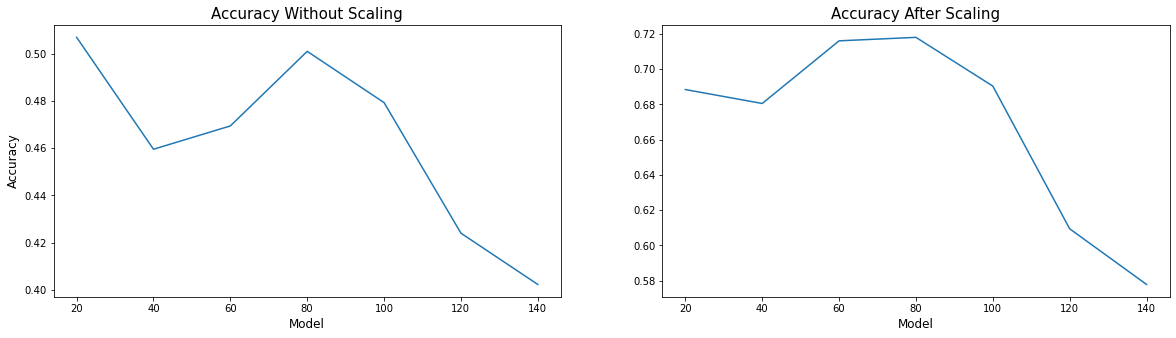

In [115]:
# plot accuracy for visualization
#Each feature set (Not Scaled Vs. Scaled)
fig = plt.figure(figsize=(20,5))
plt.subplot(121)
plt.plot([i for i, e in enumerate(data)], data); plt.xticks([i for i, e in enumerate(labels)], [l for l in labels])
plt.title("Accuracy Without Scaling",fontsize = 15)
plt.xlabel('Model',fontsize = 12)
plt.xticks(rotation = 0)
plt.ylabel('Accuracy',fontsize = 12)
plt.subplot(122)
plt.plot([i for i, e in enumerate(data_std)], data_std); plt.xticks([i for i, e in enumerate(labels_std)], [l for l in labels_std])
plt.title("Accuracy After Scaling",fontsize = 15)
plt.xlabel('Model',fontsize = 12)
plt.xticks(rotation =0)
plt.show()

In [116]:
# print each data item in dic rf_results_model2
#for key, value in rf_results_model2.items():
#    print(key)
#    print(value)

In [117]:
# Scaled is best in KNN
#Each feature set (Scaled has better scores)
#Index of the MAX accuracy element in a dictionary
the_index = rf_results_model3['accuracy'].index(max(rf_results_model3['accuracy']))
the_scale = rf_results_model3['scale'][the_index]
the_accuracy = rf_results_model3['accuracy'][the_index]
the_index, the_scale, the_accuracy

(3, 80, 0.717948717948718)

In [118]:
# recap the best model
# Scaled is best in KNN
clf_best = rf_results_model4['clf_best'][the_index]
X_train = rf_results_model4['X_train'][the_index]
Y_train = rf_results_model4['Y_train'][the_index]
X_test = rf_results_model4['X_test'][the_index]
Y_test = rf_results_model4['Y_test'][the_index]

In [119]:
# show the parameters
# Scaled is best in KNN
pars = rf_results_model4['clf_pars'][the_index]
pars

"{'metric': 'manhattan',\n 'n_neighbors': 11,\n 'p': 1,\n 'weights': 'uniform'}"

In [120]:
# Metrics
#gs_results = clf_best.fit(X_train, Y_train)
Y_hat = clf_best.predict(X_test)
print('Metrics: \n', classification_report(Y_test, Y_hat))

Metrics: 
               precision    recall  f1-score   support

    asphalt        0.83      0.67      0.74        45
   building        0.82      0.76      0.79        97
        car        0.46      0.57      0.51        21
   concrete        0.78      0.81      0.79        93
      grass        0.69      0.65      0.67        83
       pool        0.73      0.57      0.64        14
     shadow        0.73      0.78      0.75        45
       soil        0.31      0.40      0.35        20
       tree        0.71      0.76      0.74        89

    accuracy                           0.72       507
   macro avg       0.67      0.66      0.66       507
weighted avg       0.73      0.72      0.72       507

